In [1]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import os
import scikitplot as skplt
import optuna

#models 
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from xgboost import plot_importance


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
data=pd.read_csv('../final_data.csv')

In [3]:
data.head()

,CMPLNT_NUM,year,month,day,weekday,hour,Latitude,Longitude,COMPLETED,OFNS_DESC,...,JURISDICTION_CODE,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,394506329,2019,12,31,Tuesday,17,40.80,-73.94,COMPLETED,PERSONAL,...,0.0,0,0,0,UNKNOWN,UNKNOWN,U,UNKNOWN,UNKNOWN,E
1,968873685,2019,12,29,Sunday,16,40.88,-73.90,COMPLETED,PROPERTY,...,0.0,0,0,0,UNKNOWN,UNKNOWN,U,UNKNOWN,UNKNOWN,E
2,509837549,2019,12,15,Sunday,18,40.75,-73.80,COMPLETED,SEXUAL,...,0.0,0,0,0,25-44,UNKNOWN,M,25-44,WHITE HISPANIC,F
3,352454313,2019,12,28,Saturday,1,40.88,-73.90,COMPLETED,OTHER,...,0.0,0,0,0,18-24,BLACK,M,UNKNOWN,UNKNOWN,E
4,293718737,2019,12,27,Friday,22,40.72,-74.00,ATTEMPTED,PROPERTY,...,0.0,0,0,0,UNKNOWN,UNKNOWN,U,UNKNOWN,UNKNOWN,M


In [4]:
data.columns

Index(['CMPLNT_NUM', 'year', 'month', 'day', 'weekday', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'OFNS_DESC', 'ADDR_PCT_CD', 'CRIME_CLASS',
       'BORO_NM', 'PREM_TYP_DESC', 'OCCURENCE', 'JURIS_DESC',
       'JURISDICTION_CODE', 'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX'],
      dtype='object')

In [5]:
#example from the dataset
print(data.iloc[0])

CMPLNT_NUM                  394506329
year                             2019
month                              12
day                                31
weekday                       Tuesday
hour                               17
Latitude                         40.8
Longitude                      -73.94
COMPLETED                   COMPLETED
OFNS_DESC                    PERSONAL
ADDR_PCT_CD                      32.0
CRIME_CLASS                    FELONY
BORO_NM                     MANHATTAN
PREM_TYP_DESC                  STREET
OCCURENCE                     UNKNOWN
JURIS_DESC           N.Y. POLICE DEPT
JURISDICTION_CODE                 0.0
IN_PARK                             0
IN_PUBLIC_HOUSING                   0
IN_STATION                          0
SUSP_AGE_GROUP                UNKNOWN
SUSP_RACE                     UNKNOWN
SUSP_SEX                            U
VIC_AGE_GROUP                 UNKNOWN
VIC_RACE                      UNKNOWN
VIC_SEX                             E
Name: 0, dty

In [6]:
data.OFNS_DESC.unique()

array(['PERSONAL', 'PROPERTY', 'SEXUAL', 'OTHER', 'DRUGS/ALCOHOL',
       'ADMINISTRATIVE'], dtype=object)

In [7]:
filtered_df = data[~data['OFNS_DESC'].isin(['ADMINISTRATIVE', 'OTHER'])]
data=filtered_df
data.OFNS_DESC.unique()

array(['PERSONAL', 'PROPERTY', 'SEXUAL', 'DRUGS/ALCOHOL'], dtype=object)

In [8]:
# Create a dictionary to store the mapping
label_mapping = {}

# Original column values
original_values = data['OFNS_DESC'].unique()
label_encoder=LabelEncoder()
# Apply label encoding
data['target'] = label_encoder.fit_transform(data['OFNS_DESC'])

# New column values after label encoding
new_values = data['target'].unique()

# Populate the dictionary
label_mapping['original_to_encoded'] = dict(zip(original_values, new_values))
label_mapping['encoded_to_original'] = dict(zip(new_values, original_values))

# Print the dictionary
print(label_mapping)


{'original_to_encoded': {'PERSONAL': 1, 'PROPERTY': 2, 'SEXUAL': 3, 'DRUGS/ALCOHOL': 0}, 'encoded_to_original': {1: 'PERSONAL', 2: 'PROPERTY', 3: 'SEXUAL', 0: 'DRUGS/ALCOHOL'}}


In [9]:
data.columns

Index(['CMPLNT_NUM', 'year', 'month', 'day', 'weekday', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'OFNS_DESC', 'ADDR_PCT_CD', 'CRIME_CLASS',
       'BORO_NM', 'PREM_TYP_DESC', 'OCCURENCE', 'JURIS_DESC',
       'JURISDICTION_CODE', 'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'target'],
      dtype='object')

Balancing the data

In [10]:
min_count = data['target'].value_counts().min()

# Sample the same number of examples for each class
balanced_data = data.groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

In [11]:
balanced_data.target.value_counts()

target
0    530343
1    530343
2    530343
3    530343
Name: count, dtype: int64

# DATA PREPARATION
Choosing the columns that we will use in our Model

In [12]:
# Set the list of features to include in Machine Learning Model
feature_lst=['year', 'month', 'day', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'ADDR_PCT_CD',
       'BORO_NM','IN_PARK', 'IN_PUBLIC_HOUSING',
       'IN_STATION', 'VIC_AGE_GROUP', 'VIC_RACE','VIC_SEX','target']

df_sel=data[feature_lst].copy()
df_sel.info()
df_sel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6764503 entries, 0 to 7747715
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   year               int64  
 1   month              int64  
 2   day                int64  
 3   hour               int64  
 4   Latitude           float64
 5   Longitude          float64
 6   COMPLETED          object 
 7   ADDR_PCT_CD        float64
 8   BORO_NM            object 
 9   IN_PARK            int64  
 10  IN_PUBLIC_HOUSING  int64  
 11  IN_STATION         int64  
 12  VIC_AGE_GROUP      object 
 13  VIC_RACE           object 
 14  VIC_SEX            object 
 15  target             int64  
dtypes: float64(3), int64(8), object(5)
memory usage: 877.4+ MB


,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2019,12,31,17,40.80,-73.94,COMPLETED,32.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,E,1
1,2019,12,29,16,40.88,-73.90,COMPLETED,47.0,BRONX,0,0,0,UNKNOWN,UNKNOWN,E,2
2,2019,12,15,18,40.75,-73.80,COMPLETED,109.0,QUEENS,0,0,0,25-44,WHITE HISPANIC,F,3
4,2019,12,27,22,40.72,-74.00,ATTEMPTED,9.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,M,2
5,2019,12,27,20,40.70,-73.94,COMPLETED,79.0,BROOKLYN,0,0,0,UNKNOWN,UNKNOWN,E,0


In [13]:
completed_mapping={'COMPLETED':1,'ATTEMPTED':0}
# Apply the mapping to the COMPLETED column
df_sel['COMPLETED'] = df_sel['COMPLETED'].map(completed_mapping)



In [14]:
df_sel.head()

,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2019,12,31,17,40.80,-73.94,1,32.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,E,1
1,2019,12,29,16,40.88,-73.90,1,47.0,BRONX,0,0,0,UNKNOWN,UNKNOWN,E,2
2,2019,12,15,18,40.75,-73.80,1,109.0,QUEENS,0,0,0,25-44,WHITE HISPANIC,F,3
4,2019,12,27,22,40.72,-74.00,0,9.0,MANHATTAN,0,0,0,UNKNOWN,UNKNOWN,M,2
5,2019,12,27,20,40.70,-73.94,1,79.0,BROOKLYN,0,0,0,UNKNOWN,UNKNOWN,E,0


In [15]:
print(df_sel.shape)
df_sel.target.value_counts().sort_values(ascending=False)


(6764503, 16)


target
2    3784595
1    1316533
3    1133032
0     530343
Name: count, dtype: int64

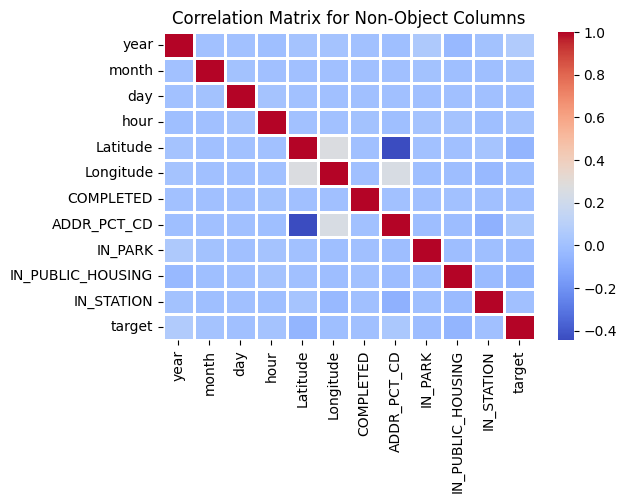

In [16]:
non_object_columns = df_sel.select_dtypes(exclude='object')

# Calculate correlation matrix
corr = non_object_columns.corr()

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap="coolwarm", linewidth=2, linecolor="white",annot=False)
plt.title("Correlation Matrix for Non-Object Columns")
plt.show()

**Deal with categorical data**

In [17]:
df = pd.get_dummies(df_sel)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6764503 entries, 0 to 7747715
Data columns (total 37 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   year                                     int64  
 1   month                                    int64  
 2   day                                      int64  
 3   hour                                     int64  
 4   Latitude                                 float64
 5   Longitude                                float64
 6   COMPLETED                                int64  
 7   ADDR_PCT_CD                              float64
 8   IN_PARK                                  int64  
 9   IN_PUBLIC_HOUSING                        int64  
 10  IN_STATION                               int64  
 11  target                                   int64  
 12  BORO_NM_BRONX                            bool   
 13  BORO_NM_BROOKLYN                         bool   
 14  BORO_NM_MANHATTAN      

change the bool columns to uint8 

In [18]:
bool_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to uint8
df[bool_columns] = df[bool_columns].astype('uint8')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6764503 entries, 0 to 7747715
Data columns (total 37 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   year                                     int64  
 1   month                                    int64  
 2   day                                      int64  
 3   hour                                     int64  
 4   Latitude                                 float64
 5   Longitude                                float64
 6   COMPLETED                                int64  
 7   ADDR_PCT_CD                              float64
 8   IN_PARK                                  int64  
 9   IN_PUBLIC_HOUSING                        int64  
 10  IN_STATION                               int64  
 11  target                                   int64  
 12  BORO_NM_BRONX                            uint8  
 13  BORO_NM_BROOKLYN                         uint8  
 14  BORO_NM_MANHATTAN      

In [20]:
del df_sel
del data

# USEFUL FUNCTIONS

In [21]:
class_names = ['PROPERTY', 'PERSONAL', 'SEXUAL', 'DRUGS/ALCOHOL']

def plot_cm(y_pred, y_test, algorithm, figure_name, class_names=None):
    mat_RF = confusion_matrix(y_pred, y_test)
    
    # Define a custom color map
    cmap = sns.color_palette("pastel", as_cmap=True)  # You can choose any seaborn color palette
    
    plt.figure(figsize=(16, 4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names, cmap=cmap)
    
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title(algorithm)
    plt.savefig(figure_name)

In [22]:
def plot_roc(X_test,y_test, model, figure_name):
    pl = skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), figsize=(12,6))
    plt.show()
    pl.figure.savefig(figure_name)

In [23]:
def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

# MODELING


In [24]:

# set X and y
y = df['target']
X = df.drop('target', axis=1)

In [25]:
y.head()


0    1
1    2
2    3
4    2
5    0
Name: target, dtype: int64

In [26]:
X.head()
# we need to rename this features because XGBOOST can't accept feature which their name contains one of this ('>','<','[',']')
X.rename(columns={'VIC_AGE_GROUP_<18': 'VIC_AGE_GROUP_-18'}, inplace=True)


In [27]:
y.value_counts()

target
2    3784595
1    1316533
3    1133032
0     530343
Name: count, dtype: int64

**split the data**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=42)


# FIRST MODEL: LGBM

In [27]:
def objective_lgbm(trial):
    # Define hyperparameters to be tuned
    params = {
        
        'objective': 'multiclass',
        'num_class':4 ,  # Number of classes
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'tree_method': 'gpu_hist',
    }

    # Create and train the LGBM model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return 1 - accuracy  # Optimize for accuracy, so use 1 - accuracy as the objective


In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=10)

# Print the best parameters and their corresponding objective value
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-26 17:50:47,322] A new study created in memory with name: no-name-7fc78448-a885-46f6-bc90-1acb5d99c1e7


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6377744365605518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377744365605518
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.11872885808571708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11872885808571708


[I 2023-12-26 17:53:11,927] Trial 0 finished with value: 0.36703933078145146 and parameters: {'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.07136798356012823, 'feature_fraction': 0.6377744365605518, 'bagging_fraction': 0.11872885808571708, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5896568155555428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896568155555428
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9130301020682628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130301020682628


[I 2023-12-26 17:58:23,118] Trial 1 finished with value: 0.36841119726888194 and parameters: {'boosting': 'gbdt', 'num_leaves': 167, 'learning_rate': 0.029103204106496514, 'feature_fraction': 0.5896568155555428, 'bagging_fraction': 0.9130301020682628, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.14044090510817825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14044090510817825
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.1074615404693465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1074615404693465


[I 2023-12-26 18:00:22,941] Trial 2 finished with value: 0.399778845661078 and parameters: {'boosting': 'gbdt', 'num_leaves': 193, 'learning_rate': 0.021730483225044388, 'feature_fraction': 0.14044090510817825, 'bagging_fraction': 0.1074615404693465, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5078513087756803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5078513087756803
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3934040247673316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3934040247673316


[I 2023-12-26 18:03:22,776] Trial 3 finished with value: 0.3715826529847951 and parameters: {'boosting': 'gbdt', 'num_leaves': 112, 'learning_rate': 0.02250169776155331, 'feature_fraction': 0.5078513087756803, 'bagging_fraction': 0.3934040247673316, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5060596323680536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060596323680536
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5503631156080332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5503631156080332


[I 2023-12-26 18:05:54,882] Trial 4 finished with value: 0.3736335539620529 and parameters: {'boosting': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.0262775923302268, 'feature_fraction': 0.5060596323680536, 'bagging_fraction': 0.5503631156080332, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.1429148467623674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1429148467623674
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.46629511378113675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46629511378113675


[I 2023-12-26 18:07:22,020] Trial 5 finished with value: 0.3767547473282111 and parameters: {'boosting': 'gbdt', 'num_leaves': 11, 'learning_rate': 0.08389528038804187, 'feature_fraction': 0.1429148467623674, 'bagging_fraction': 0.46629511378113675, 'bagging_freq': 3, 'min_child_samples': 2}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.12010386318743314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12010386318743314
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.33468404319956546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33468404319956546


[I 2023-12-26 18:09:30,702] Trial 6 finished with value: 0.3900486460702727 and parameters: {'boosting': 'gbdt', 'num_leaves': 182, 'learning_rate': 0.045979017377381755, 'feature_fraction': 0.12010386318743314, 'bagging_fraction': 0.33468404319956546, 'bagging_freq': 10, 'min_child_samples': 12}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.4067294252565973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4067294252565973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.3615411035653108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3615411035653108


[I 2023-12-26 18:12:18,973] Trial 7 finished with value: 0.3680150116884602 and parameters: {'boosting': 'gbdt', 'num_leaves': 95, 'learning_rate': 0.059697240281909064, 'feature_fraction': 0.4067294252565973, 'bagging_fraction': 0.3615411035653108, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.1544824752334853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1544824752334853
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6902506818201409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6902506818201409


[I 2023-12-26 18:15:16,691] Trial 8 finished with value: 0.37470187527841403 and parameters: {'boosting': 'gbdt', 'num_leaves': 115, 'learning_rate': 0.07627139638047221, 'feature_fraction': 0.1544824752334853, 'bagging_fraction': 0.6902506818201409, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 0 with value: 0.36703933078145146.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.49520139192115276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49520139192115276
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6989873027720169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6989873027720169


[I 2023-12-26 18:17:55,986] Trial 9 finished with value: 0.36949430162928854 and parameters: {'boosting': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.07818296967994562, 'feature_fraction': 0.49520139192115276, 'bagging_fraction': 0.6989873027720169, 'bagging_freq': 10, 'min_child_samples': 1}. Best is trial 0 with value: 0.36703933078145146.


Best trial:
  Value: 0.367
  Params: 
    boosting: gbdt
    num_leaves: 189
    learning_rate: 0.07136798356012823
    feature_fraction: 0.6377744365605518
    bagging_fraction: 0.11872885808571708
    bagging_freq: 4
    min_child_samples: 5


In [43]:
newparams = {'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.07136798356012823, 'feature_fraction': 0.6377744365605518, 'bagging_fraction': 0.11872885808571708, 'bagging_freq': 4, 'min_child_samples': 5}
print(newparams)

{'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.07136798356012823, 'feature_fraction': 0.6377744365605518, 'bagging_fraction': 0.11872885808571708, 'bagging_freq': 4, 'min_child_samples': 5}


In [44]:
modellbg = lgb.LGBMClassifier(**newparams)
modellbg.fit(X_train, y_train)
y_pred = modellbg.predict(X_test)

[LightGBM] [Warning] bagging_fraction is set=0.11872885808571708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11872885808571708
[LightGBM] [Warning] feature_fraction is set=0.6377744365605518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377744365605518
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


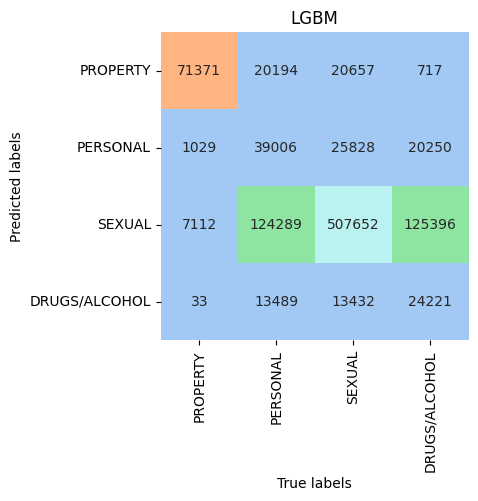

In [45]:
plot_cm(y_pred, y_test, 'LGBM', 'lgbm_confusion_matrix.jpg', class_names)


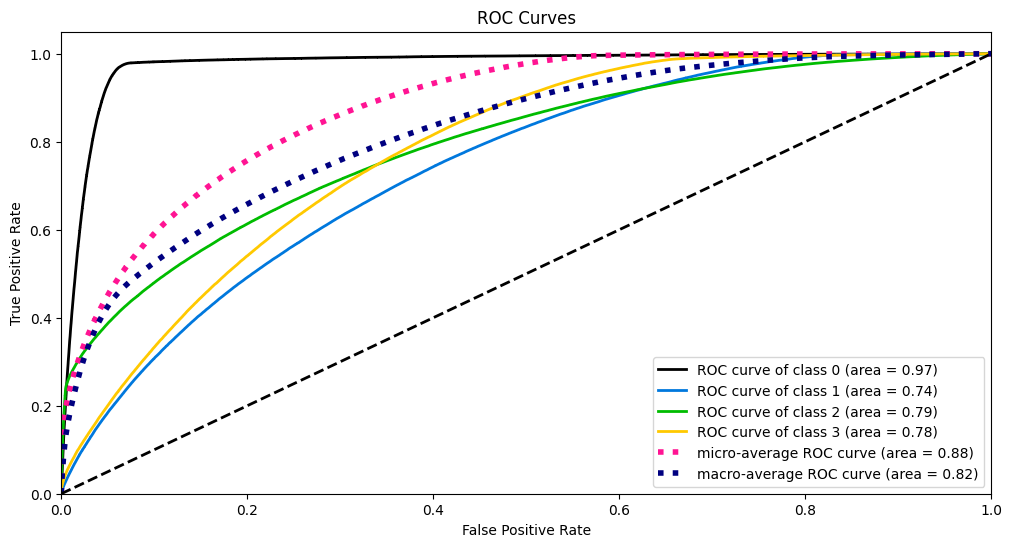

In [46]:
plot_roc(X_test,y_test, modellbg, 'lgbm_roc.jpg')

In [72]:
accuracy = accuracy_score(y_pred, y_test)
print('lgbm Model accuracy score: {0:0.4f}'.format(accuracy_score(y_otte, y_pred)))

lgbm Model accuracy score: 0.6342


In [48]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.63      0.90      0.74     79545
           1       0.45      0.20      0.28    196978
           2       0.66      0.89      0.76    567569
           3       0.47      0.14      0.22    170584

    accuracy                           0.63   1014676
   macro avg       0.56      0.53      0.50   1014676
weighted avg       0.59      0.63      0.57   1014676



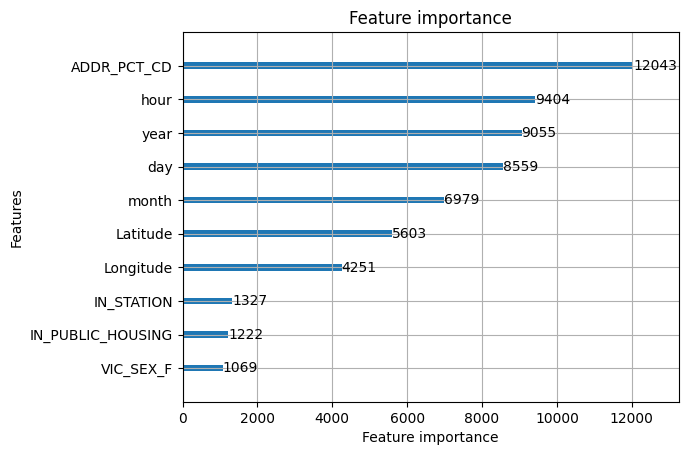

In [49]:
lgb.plot_importance(modellbg, importance_type='split', max_num_features=10)  # You can adjust max_num_features as needed
plt.show()

In [63]:
save_model(modellbg, "lgbm")

Model size: 7.85 MB


# SECOND MODEL XGBOOST

**Hyperparams Tuning**

In [34]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 4,  # Assuming a classification task with 3 classes
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'tree_method' : "hist",
        'device' : "cuda",
        'verbosity': 1,
        'n_jobs': -1,  # Utilize all available CPU cores
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)

In [35]:
# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=4)

# Print the best parameters and their corresponding objective value
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-26 18:20:45,746] A new study created in memory with name: no-name-6a990c2b-fc71-4719-9957-4caf74a214fa
[18:21:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[18:21:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[18:21:52] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
[18:21:52] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.

KeyboardInterrupt



**Training model with best hyperparams**

In [56]:
bestparams = {
    'max_depth': 5,
    'learning_rate': 0.08282636175249172,
    'n_estimators': 60,
    'subsample': 0.4797848260397173,
    'colsample_bytree': 0.2619387039103879,
    'min_child_weight': 7.470308349969615,
    'objective': 'multi:softmax',  # Already included in your code
    'num_class': 6,               # Already included in your code
    'tree_method': 'gpu_hist',    # Enable GPU acceleration
    'predictor': 'gpu_predictor'  # Use GPU for prediction
}

modelxgb = xgb.XGBClassifier(**bestparams)  
modelxgb.fit(X_train, y_train)
y_pred = modelxgb.predict(X_test)

**Evaluation**

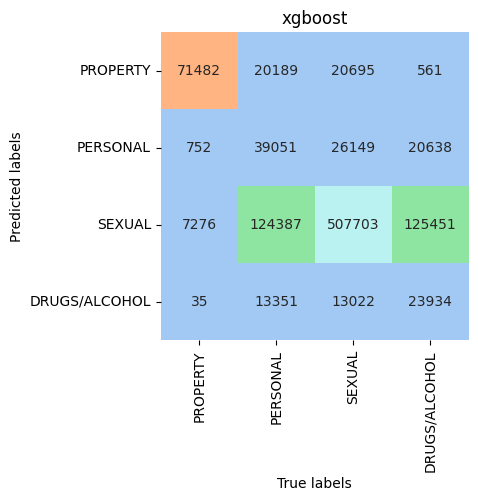

In [57]:
plot_cm(y_pred, y_test, 'xgboost', 'xgboost_confusion_matrix.jpg', class_names)


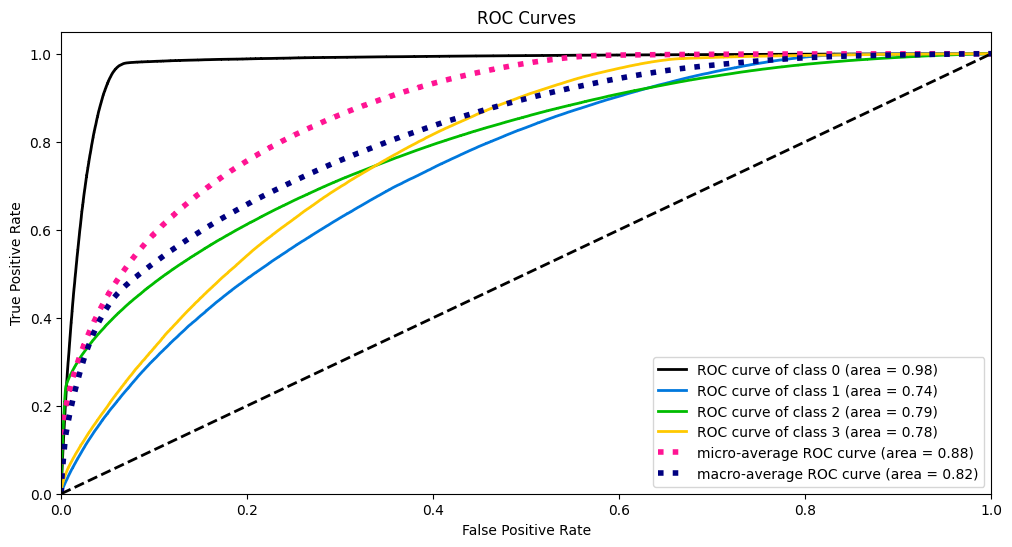

In [58]:
plot_roc(X_test,y_test, modelxgb, 'xgboost_roc.jpg')

In [59]:
class_report = classification_report(y_test, y_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.63      0.90      0.74     79545
           1       0.45      0.20      0.28    196978
           2       0.66      0.89      0.76    567569
           3       0.48      0.14      0.22    170584

    accuracy                           0.63   1014676
   macro avg       0.56      0.53      0.50   1014676
weighted avg       0.59      0.63      0.57   1014676



In [60]:
accuracy = accuracy_score(y_pred, y_test)
print('XGBBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


XGBBoost Model accuracy score: 0.6329


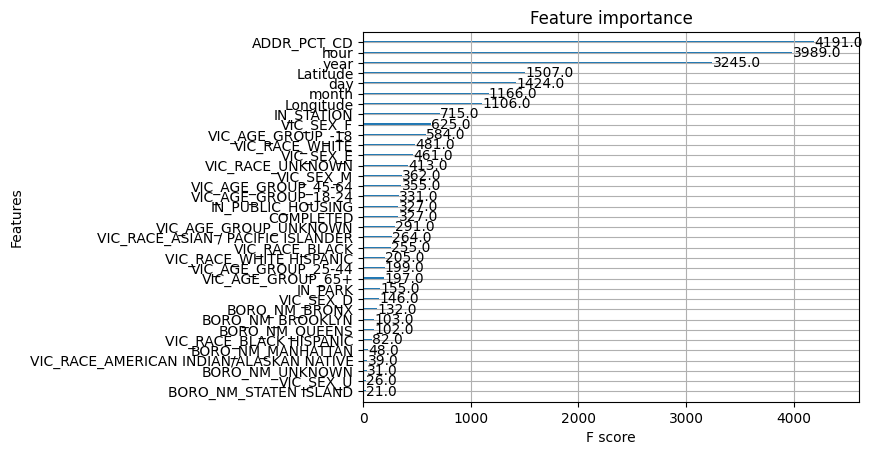

In [61]:
plot_importance(modelxgb)
plt.show()

In [64]:
save_model(modelxgb, "modelxgboost")

Model size: 1.82 MB


# THIRD MODEL : CATBBOST

In [58]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'loss_function': 'MultiClass',
        'verbose': 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose_eval=False)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)


In [59]:
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10)

# Print the best parameters and their corresponding objective value for CatBoost
print("Best trial for CatBoost:")
trial_catboost = study_catboost.best_trial
print("  Value: {:.3f}".format(trial_catboost.value))
print("  Params: ")
for key, value in trial_catboost.params.items():
    print("    {}: {}".format(key, value))


[I 2023-12-26 19:55:01,916] A new study created in memory with name: no-name-a9481398-b101-487b-8798-3592db1d2817
[W 2023-12-26 20:51:31,299] Trial 0 failed with parameters: {'iterations': 176, 'depth': 6, 'learning_rate': 0.03997159728217794, 'l2_leaf_reg': 8.437243368394324, 'border_count': 45, 'colsample_bylevel': 0.9133909906838263, 'min_child_samples': 1} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_42/3370333682.py", line 15, in objective_catboost
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose_eval=False)
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.10/si

In [29]:
"""best_params_catboost = {
    'iterations': trial_catboost.params['iterations'],
    'depth': trial_catboost.params['depth'],
    'learning_rate': trial_catboost.params['learning_rate'],
    'l2_leaf_reg': trial_catboost.params['l2_leaf_reg'],
    'border_count': trial_catboost.params['border_count'],
    'colsample_bylevel': trial_catboost.params['colsample_bylevel'],
    'min_child_samples': trial_catboost.params['min_child_samples'],
    'loss_function': 'MultiClass',
    'num_class': 4,
    'verbose': 0,
}"""

best_params_catboost = {
    'iterations': 1200,
    'depth': 7,
    'learning_rate': 0.08,
    'l2_leaf_reg': 4,
    'border_count': 198,
    'colsample_bylevel':0.44,
    'min_child_samples': 12,
    'loss_function': 'MultiClass',
    'verbose': 0,
}

print(best_params_catboost)

{'iterations': 1200, 'depth': 7, 'learning_rate': 0.08, 'l2_leaf_reg': 4, 'border_count': 198, 'colsample_bylevel': 0.44, 'min_child_samples': 12, 'loss_function': 'MultiClass', 'verbose': 0}


In [30]:
# Use the best parameters to train the CatBoost model
model_catboost = CatBoostClassifier(**best_params_catboost)
model_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose_eval=False)
y_pred_catboost = model_catboost.predict(X_test)


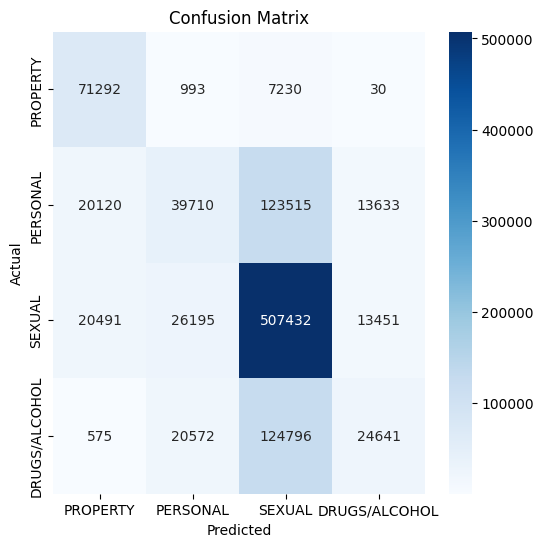

In [38]:
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

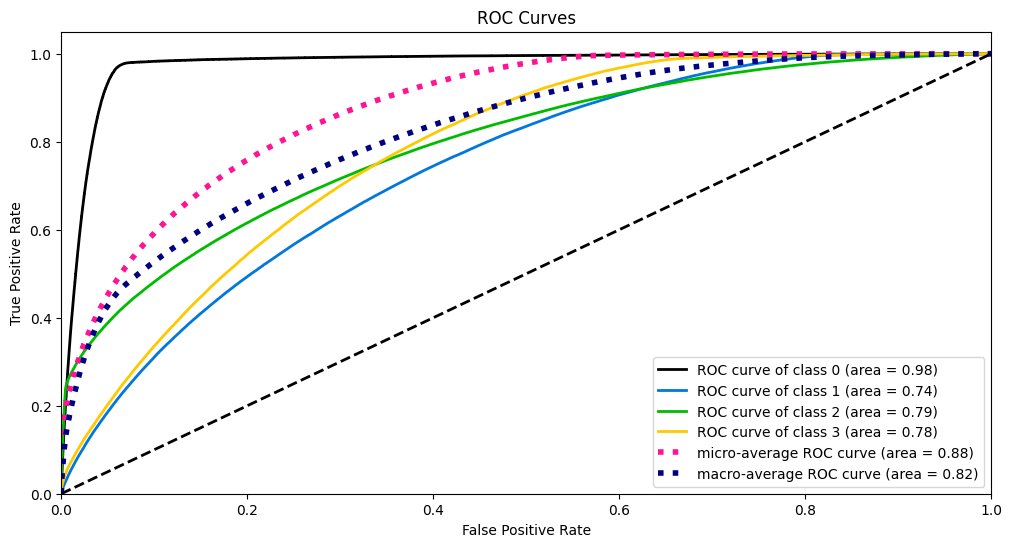

In [32]:
plot_roc(X_test, y_test, model_catboost, 'catboost_roc.jpg')


In [33]:
class_report_catboost = classification_report(y_test, y_pred_catboost)
print(class_report_catboost)

              precision    recall  f1-score   support

           0       0.63      0.90      0.74     79545
           1       0.45      0.20      0.28    196978
           2       0.67      0.89      0.76    567569
           3       0.48      0.14      0.22    170584

    accuracy                           0.63   1014676
   macro avg       0.56      0.53      0.50   1014676
weighted avg       0.59      0.63      0.58   1014676



In [34]:
print(mean_squared_error(y_test, y_pred_catboost, squared=False))
accuracy_catboost = accuracy_score(y_pred_catboost, y_test)
print('CatBoost Model accuracy score: {0:0.4f}'.format(accuracy_catboost))

0.7443703486959458
CatBoost Model accuracy score: 0.6338


In [65]:
save_model(model_catboost, "model_catboost")

Model size: 40.79 MB
